   ID  Video Duration   Video Publish Time  Days Since Publish  Day  Month  \
0   0          201.00  2016-06-02 00:00:00                   0    2      6   
1   1          391.00  2016-06-10 00:00:00                   8   10      6   
2   2          133.00  2016-06-14 00:00:00                   4   14      6   
3   3           14.00  2016-06-29 00:00:00                  15   29      6   
4   4           45.00  2016-07-01 00:00:00                   2    1      7   

   Year Day of Week  Revenue per 1000 Views (USD)  \
0  2016    Thursday                          0.02   
1  2016      Friday                          0.06   
2  2016     Tuesday                          0.01   
3  2016   Wednesday                          0.00   
4  2016      Friday                          0.00   

   Monetized Playbacks (Estimate)  ...  Watched (Not Skipped) (%)  \
0                          723.00  ...                       0.00   
1                          727.00  ...                       0.00   
2    

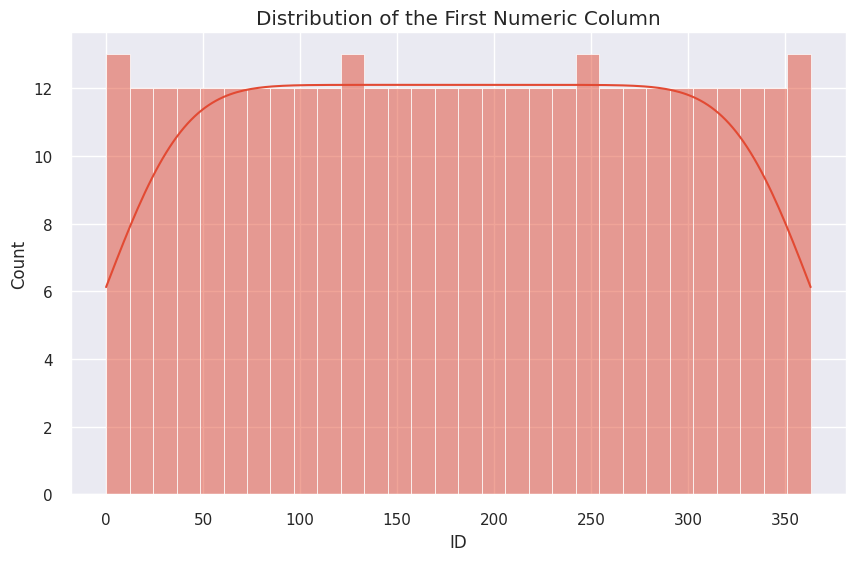

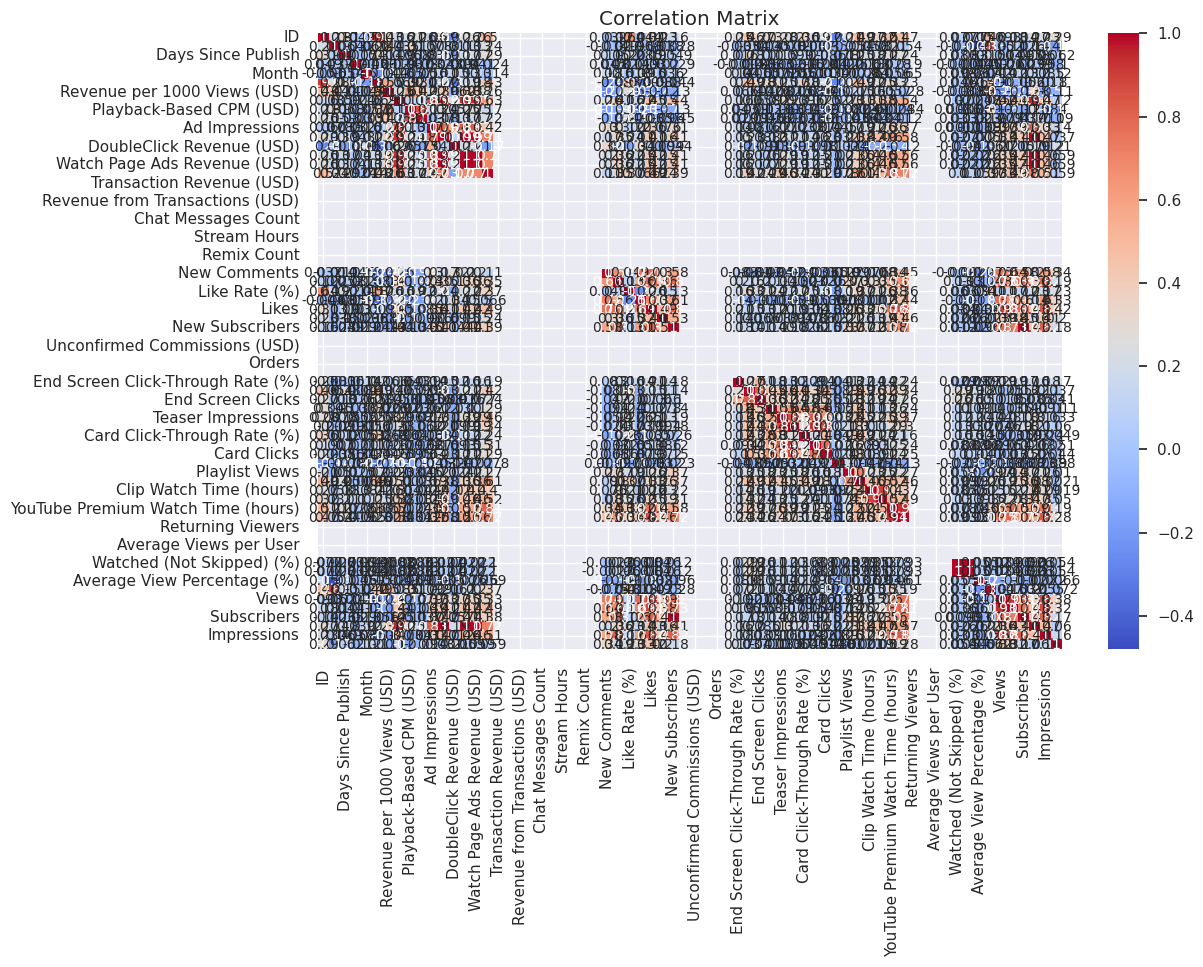

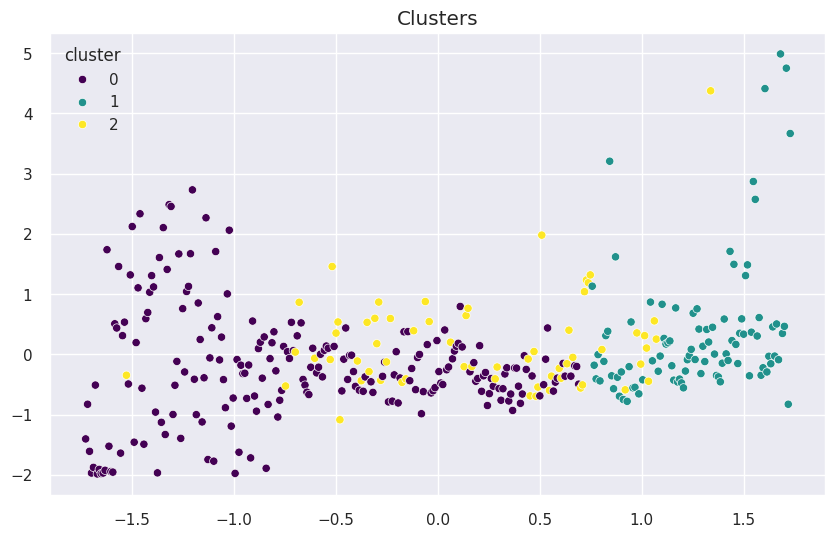

Anomalies detected: anomaly
 1    345
-1     19
Name: count, dtype: int64


,Description,Value
0,session_id,42
1,Target,Estimated Revenue (USD)
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(364, 70)"
5,Transformed data shape,"(364, 70)"
6,Transformed train set shape,"(363, 70)"
7,Transformed test set shape,"(1, 70)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,TT (Sec)
arima,ARIMA,0.0000,0.0000,0.0002,0.0002,0.0000,0.0000,3.0433
auto_arima,Auto ARIMA,0.0000,0.0000,0.0002,0.0002,0.0000,0.0000,35.8867
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.1410,0.0871,1.4638,1.4638,0.2329,0.2776,0.9167
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.1580,0.0976,1.6400,1.6400,0.2558,0.3072,0.1867
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.2014,0.1243,2.0885,2.0885,0.4240,0.3103,0.0967
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.2083,0.1286,2.1602,2.1602,0.4395,0.3178,0.0900
catboost_cds_dt,CatBoost Regressor w/ Cond. Deseasonalize & Detrending,0.2087,0.1290,2.1686,2.1686,0.2394,0.2870,5.4567
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.2125,0.1313,2.2063,2.2063,0.3227,0.3914,0.9000
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.2140,0.1322,2.2221,2.2221,0.3230,0.3913,0.1000
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.2140,0.1322,2.2221,2.2221,0.3230,0.3913,0.1067


Processing:   0%|          | 0/89 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved


(ForecastingPipeline(steps=[('forecaster',
                             TransformedTargetForecaster(steps=[('model',
                                                                 ForecastingPipeline(steps=[('forecaster',
                                                                                             TransformedTargetForecaster(steps=[('model',
                                                                                                                                 ARIMA(seasonal_order=(0,
                                                                                                                                                       1,
                                                                                                                                                       0,
                                                                                                                                                       29)))]))]))]))]),
 'tabul

In [18]:
# Install necessary libraries
!pip install pandas numpy matplotlib seaborn plotly pycaret

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pycaret.regression import *
from pycaret.time_series import *

# ========== PART 1: Tabular Dataset ==========
# Load the tabular dataset
tabular_url = "youtube_channel_real_performance_analytics.csv"
tabular_df = pd.read_csv(tabular_url)

# ======= a) Detailed EDA, Visualization, and Preprocessing =======
# Preview dataset
print(tabular_df.head())
print(tabular_df.info())
print(tabular_df.describe())

# Handle missing values
tabular_df = tabular_df.dropna()  # Drop rows with missing values

# Visualization example
plt.figure(figsize=(10, 6))
sns.histplot(tabular_df.select_dtypes(include=np.number).iloc[:, 0], bins=30, kde=True)  # Use the first numeric column
plt.title('Distribution of the First Numeric Column')
plt.show()

# Filter numeric columns
numeric_cols = tabular_df.select_dtypes(include=np.number)

# Compute and plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# ======= b) Clustering and Anomaly Elimination =======
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# Scaling numeric data
numeric_cols = tabular_df.select_dtypes(include=np.number)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_cols)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
tabular_df['cluster'] = kmeans.fit_predict(scaled_data)

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_data[:, 0], y=scaled_data[:, 1], hue=tabular_df['cluster'], palette="viridis")
plt.title("Clusters")
plt.show()

# Isolation Forest for anomaly detection
iso = IsolationForest(contamination=0.05, random_state=42)
tabular_df['anomaly'] = iso.fit_predict(numeric_cols)
print(f"Anomalies detected: {tabular_df['anomaly'].value_counts()}")

# ======= c) Build ML Models Using PyCaret =======
# Ensure the target column is numeric
tabular_df['Estimated Revenue (USD)'] = pd.to_numeric(tabular_df['Estimated Revenue (USD)'], errors='coerce')

# Drop rows with missing values in the target column
tabular_df = tabular_df.dropna(subset=['Estimated Revenue (USD)'])

# Select only numeric columns
numeric_cols = tabular_df.select_dtypes(include=np.number)

# Use only numeric features and reset the index
tabular_df = numeric_cols.copy()
tabular_df.reset_index(drop=True, inplace=True)

# Set up PyCaret for regression
setup(data=tabular_df, target='Estimated Revenue (USD)', session_id=42)

# Compare models
best_model = compare_models()

# Finalize the best model
final_model = finalize_model(best_model)

# Save the model
save_model(final_model, 'tabular_model')

In [46]:
# ========== PART 2: Time-Series Dataset ==========
# Load the time-series dataset
time_series_url = "DailyDelhiClimateTest.csv"
time_series_df = pd.read_csv(time_series_url, parse_dates=["date"], index_col="date")

# ======= a) Detailed EDA, Visualization, and Preprocessing =======
# Preview dataset
print(time_series_df.head())
print(time_series_df.info())

# Ensure target column is numeric
time_series_df['humidity'] = pd.to_numeric(time_series_df['humidity'], errors='coerce')
time_series_df['humidity'].fillna(time_series_df['humidity'].mean(), inplace=True)

# Ensure the index is datetime
time_series_df.index = pd.to_datetime(time_series_df.index)

# Identify and remove constant columns
constant_columns = [col for col in time_series_df.columns if time_series_df[col].nunique() <= 1]
print("Constant Columns Removed:", constant_columns)
time_series_df.drop(columns=constant_columns, inplace=True)

# Set up PyCaret
setup(data=time_series_df, target='humidity', fold=3, session_id=42)

# Create and finalize the ARIMA model
model = create_model('arima')
final_model = finalize_model(model)

# Save the model
save_model(final_model, 'time_series_model')

            meantemp  humidity  wind_speed  meanpressure
date                                                    
2017-01-01     15.91     85.87        2.74         59.00
2017-01-02     18.50     77.22        2.89      1,018.28
2017-01-03     17.11     81.89        4.02      1,018.33
2017-01-04     18.70     70.05        4.54      1,015.70
2017-01-05     18.39     74.94        3.30      1,014.33
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2017-01-01 to 2017-04-24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      114 non-null    float64
 1   humidity      114 non-null    float64
 2   wind_speed    114 non-null    float64
 3   meanpressure  114 non-null    float64
dtypes: float64(4)
memory usage: 4.5 KB
None
Constant Columns Removed: []


,Description,Value
0,session_id,42
1,Target,humidity
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(114, 4)"
5,Transformed data shape,"(114, 4)"
6,Transformed train set shape,"(113, 4)"
7,Transformed test set shape,"(1, 4)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2017-04-20,2.0116,1.5974,11.7867,11.7867,0.2993,0.3520
1,2017-04-21,0.0356,0.0283,0.2103,0.2103,0.0051,0.0051
2,2017-04-22,2.2084,1.7532,12.9730,12.9730,0.4717,0.3817
Mean,NaT,1.4185,1.1263,8.3233,8.3233,0.2587,0.2463
SD,NaT,0.9812,0.7790,5.7572,5.7572,0.1926,0.1710


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved


(ForecastingPipeline(steps=[('forecaster',
                             TransformedTargetForecaster(steps=[('model',
                                                                 ForecastingPipeline(steps=[('forecaster',
                                                                                             TransformedTargetForecaster(steps=[('model',
                                                                                                                                 ARIMA())]))]))]))]),
 'time_series_model.pkl')